In [1]:
import numpy as np
import jax
import jax.numpy as jnp
import chex
from functools import partial
from typing import Callable
import os
from exciting_environments import PMSM, IM
import matplotlib.pyplot as plt
import jax_dataclasses as jdc
from exciting_environments.utils import MinMaxNormalization
jax.config.update("jax_enable_x64", True) 

2025-10-31 12:06:17.226806: W external/xla/xla/service/gpu/nvptx_compiler.cc:760] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.9.86). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [2]:
BATCH_SIZE=1
new_motor_env = IM(
    batch_size=BATCH_SIZE,
    control_state=["torque"]
    )

In [61]:
PRNGKey = jax.vmap(jax.random.PRNGKey)(np.random.randint(0, 2**31, size=(BATCH_SIZE,)))
obs, motor_env_state = new_motor_env.reset(new_motor_env.env_properties,PRNGKey[0]) #PRNGKey
motor_env_state.physical_state

IM.PhysicalState(u_alpha_buffer=0.0, u_beta_buffer=0.0, i_s_alpha=Array(-2.45965644, dtype=float64), i_s_beta=Array(0.61998907, dtype=float64), psi_r_alpha=Array(-0.35776821, dtype=float64), psi_r_beta=Array(0.09018023, dtype=float64), epsilon=Array(-1.68680356, dtype=float64), omega_el=Array(297.40391159, dtype=float64), torque=Array(-7.99999464e-17, dtype=float64))

In [40]:
def gym_electric_motor_step(params,omega,i_alpha,i_beta,psi_alpha,psi_beta,eps,u_s_alpha,u_s_beta):
    l_s = params.l_m  + params.l_sigs 
    l_r = params.l_m  + params.l_sigr
    sigma = (l_s * l_r - params.l_m ** 2) / (l_s * l_r)
    tau_r = l_r / params.r_r
    tau_sig = sigma * l_s / (params.r_s + params.r_r * (params.l_m ** 2) / (l_r**2))

    model_constants = np.array([
        # omega, i_alpha, i_beta, psi_ralpha, psi_rbeta, omega * psi_ralpha, omega * psi_rbeta, u_salpha, u_sbeta, u_ralpha, u_rbeta,
        [0, -1 / tau_sig, 0,params.l_m * params.r_r / (sigma * l_s * l_r ** 2), 0, 0,
            +params.l_m * params.p / (sigma * l_r * l_s), 1 / (sigma * l_s), 0,
            -params.l_m / (sigma * l_r * l_s), 0, ],  # i_ralpha_dot
        [0, 0, -1 / tau_sig, 0,
            params.l_m * params.r_r / (sigma * l_s * l_r ** 2),
            -params.l_m * params.p / (sigma * l_r * l_s), 0, 0,
            1 / (sigma * l_s), 0, -params.l_m / (sigma * l_r * l_s), ],
        # i_rbeta_dot
        [0, params.l_m/ tau_r, 0, -1 / tau_r, 0, 0, -params.p, 0, 0, 1,
            0, ],  # psi_ralpha_dot
        [0, 0, params.l_m / tau_r, 0, -1 / tau_r, params.p, 0, 0, 0, 0, 1, ],
        # psi_rbeta_dot
        [params.p, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],  # epsilon_dot
    ])

    dstate_dt= np.matmul(
            model_constants,
            np.array(
                [
                    # omega, i_alpha, i_beta, psi_ralpha, psi_rbeta, omega * psi_ralpha, omega * psi_rbeta, u_salpha, u_sbeta, u_ralpha, u_rbeta,
                    omega,
                    i_alpha,
                    i_beta,
                    psi_alpha,
                    psi_beta,
                    omega * psi_alpha,
                    omega * psi_beta,
                    u_s_alpha,
                    u_s_beta,
                    0.0,
                    0.0,
                ]
            ),
        )
    i_alpha_k1 = i_alpha + dstate_dt[0] * 1e-4
    i_beta_k1 = i_beta + dstate_dt[1] * 1e-4
    psi_alpha_k1 = psi_alpha + dstate_dt[2] * 1e-4
    psi_beta_k1 = psi_beta + dstate_dt[3] * 1e-4
    epsilon_k1 = eps + dstate_dt[4] * 1e-4

    return np.array([i_alpha_k1, i_beta_k1, psi_alpha_k1, psi_beta_k1, epsilon_k1])

In [62]:
action=jnp.array([0.5,0.32])
action_denorm= new_motor_env.env_properties.action_normalizations.u_alpha.denormalize(action)
gymstate=gym_electric_motor_step(new_motor_env.env_properties.static_params,
                                 motor_env_state.physical_state.omega_el/2,
                                 motor_env_state.physical_state.i_s_alpha, 
                                 motor_env_state.physical_state.i_s_beta,
                                 motor_env_state.physical_state.psi_r_alpha,
                                 motor_env_state.physical_state.psi_r_beta,
                                 motor_env_state.physical_state.epsilon,
                                 action_denorm[0],
                                 action_denorm[1])

In [63]:
bs_next,next_state=new_motor_env.step(motor_env_state,action,env_properties=new_motor_env.env_properties)

In [64]:
print(jnp.isclose(jnp.array(gymstate[0]),next_state.physical_state.i_s_alpha))
print(jnp.isclose(jnp.array(gymstate[1]),next_state.physical_state.i_s_beta))
print(jnp.isclose(jnp.array(gymstate[2]),next_state.physical_state.psi_r_alpha))
print(jnp.isclose(jnp.array(gymstate[3]),next_state.physical_state.psi_r_beta))
print(jnp.isclose(jnp.array(gymstate[4]),next_state.physical_state.epsilon))

True
True
True
True
True


### Other small tests

In [ ]:
obs, motor_env_state = new_motor_env.vmap_reset() #PRNGKey
next_state=motor_env_state
i_dqs=[]
for _ in range(25):
    act=jnp.repeat(jnp.array([-1.0,1.0])[:,None],BATCH_SIZE,axis=1).T
    obs_next,next_state=new_motor_env.vmap_step(next_state,act)
    i_dqs.append(obs_next[0,0:2])

Text(0, 0.5, 'i_beta')

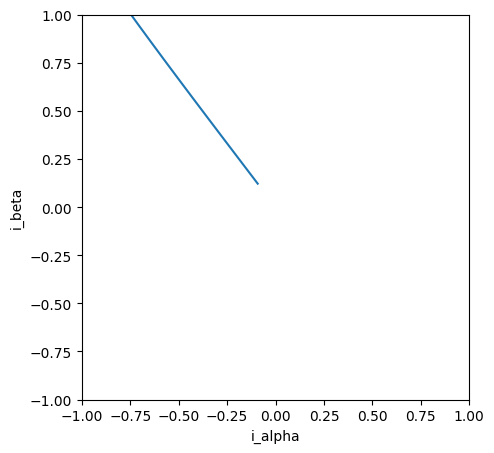

In [20]:
fig,ax=plt.subplots(1,1,figsize=(5,5))
ax.plot(jnp.array(i_dqs)[:,0],jnp.array(i_dqs)[:,1])
ax.set_xlim(-1,1)
ax.set_ylim(-1,1)
ax.set_xlabel("i_alpha")
ax.set_ylabel("i_beta")


### PMSM with GymWrapper

In [6]:
from exciting_environments import GymWrapper

In [ ]:
gym_pmsm= GymWrapper(env=new_motor_env)

In [ ]:
gym_pmsm.reset()
i_dqs2=[]
for _ in range(1000):
    act=jnp.repeat(jnp.array([0.03,0.03])[:,None],BATCH_SIZE,axis=1).T
    obs_next,_,_,_=gym_pmsm.step(act)
    i_dqs2.append(obs_next[0,0:2])

In [ ]:
fig,ax=plt.subplots(1,1,figsize=(5,5))
ax.plot(jnp.array(i_dqs2)[:,0],jnp.array(i_dqs2)[:,1])
ax.set_xlim(-1,1)
ax.set_ylim(-1,1)
ax.set_xlabel("i_d")
ax.set_ylabel("i_q")